## ASG

In [0]:
%load_ext autoreload
%autoreload 2

from src.plot_utils import *
from src.models.ASG import *
from src.algorithms import *

latexify(columns=1)


f = Kink2D()
X_test = random_hypercube_samples(1000, f.bounds)
# Uses uniform since bounds are [0,1] to ensure implementation is not broken...
X_test = np.random.uniform(size=(1000,2))
N_test = X_test.shape[-1]
Y_test = f(X_test)

def calc_error(i, model):
    max_error, L2_err = model.calc_error(X_test, Y_test)
    print("{0:9d} {1:9d}  Loo={2:1.2e}  L2={3:1.2e}".format(i+1, model.grid.getNumPoints(), max_error, L2_err))


In [0]:

# f = Sinc2D() # Behaves weirdly with nothing plotted for non-adaptive, and adaptive cannot capture the rotated embedding.

# Without Adaptive
asg = AdaptiveSparseGrid(f, depth=15, refinement_level=0)
asg.fit(callback=calc_error)
fig = asg.plot()

# I should be able to get good performance with non-adaptive SG with 3e5 points.


In [0]:
f = KinkDCircularEmbedding(D=2)
asg = AdaptiveSparseGrid(f, depth=1, refinement_level=20, f_tol=1e-3)
asg.fit(callback=calc_error)

X_train = asg.grid.getLoadedPoints()

fig = plt.figure()
XY, X, Y = construct_2D_grid(f.bounds)
ax = fig.add_subplot(222)
Z2 = call_function_on_grid(asg.evaluate, XY)[...,0]
cont = ax.contourf(X,Y,Z2, 50)
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$")
fig.colorbar(cont)
sns.scatterplot(X_train[...,0], X_train[...,1], ax=ax, s=2, alpha=0.5, linewidth=0.4, legend=False)

savefig(fig, 'DKL/A-SG-failure.pdf')



In [0]:

# Extremely sensitive to f_tol (0.0099 works, >=0.01 breaks)

# Adaptive
asg = AdaptiveSparseGrid(f, depth=1, refinement_level=30, f_tol=0.0099)
asg.fit(callback=calc_error)
fig = asg.plot()
#savefig(fig, 'ASG/Kink2D.pgf')


In [0]:

# L2 and Loo as function of #points

refinement_levels = 30
f_tol = 0.0099

def test_depth_to_error(ASG_creator, max_points=4e5):
    N = np.empty(refinement_levels)
    Loo_err = np.empty(refinement_levels)
    L2_err = np.empty(refinement_levels)

    for i in range(refinement_levels):
        ASG = ASG_creator(i)
        ASG.fit()

        N[i] = ASG.grid.getNumPoints()
        Loo_err[i], L2_err[i] = ASG.calc_error(X_test, Y_test)
        
        if N[i] > max_points:
            break

    return N[:i], Loo_err[:i], L2_err[:i]

N, Loo_err, L2_err = test_depth_to_error(lambda i: AdaptiveSparseGrid(f, depth=i, refinement_level=0, f_tol=f_tol))
fig, ax = plt.subplots()
ax.plot(N, Loo_err, label="$L_\infty$ error - SG", marker='*', c='black')
ax.plot(N, L2_err, label="$L_2$ error - SG", marker=11, c='black')

N, Loo_err, L2_err = test_depth_to_error(lambda i: AdaptiveSparseGrid(f, depth=1, refinement_level=i, f_tol=f_tol))
ax.plot(N, Loo_err, label="$L_\infty$ error - ASG", marker='*', dashes=[2,2], c='black')
ax.plot(N, L2_err, label="$L_2$ error - ASG", marker=11,  dashes=[2,2], c='black')

ax.set_xlabel('\#Points N')
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()
savefig(fig, 'ASG/depth_to_error.pdf')



In [0]:
# Error as function of Threshold 

thresholds = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

def test_depth_to_error(ASG_creator, max_points=4e5):
    Loo_err = np.empty(len(thresholds))
    L2_err = np.empty(len(thresholds))

    for i, threshold in enumerate(thresholds):
        ASG = ASG_creator(threshold)
        print("Threshold={}   N={}".format(threshold, ASG.grid.getNumPoints()))
        ASG.fit()

        Loo_err[i], L2_err[i] = ASG.calc_error(X_test, Y_test)

    return Loo_err[:i], L2_err[:i]


Loo_err, L2_err = test_depth_to_error(lambda threshold: AdaptiveSparseGrid(f, depth=15, refinement_level=0, f_tol=threshold))
fig, ax = plt.subplots()
ax.plot(thresholds, Loo_err, label="$L_\infty$ error - SG", marker='*')
ax.plot(thresholds, L2_err, label="$L_2$ error - SG", marker=11)

Loo_err, L2_err = test_depth_to_error(lambda threshold: AdaptiveSparseGrid(f, depth=30, refinement_level=1, f_tol=threshold))
ax.plot(thresholds, Loo_err, label="$L_\infty$ error - ASG", marker='*')
ax.plot(thresholds, L2_err, label="$L_2$ error - ASG", marker=11)

ax.set_xlabel('Thresholds')
ax.set_ylabel('Error')
ax.set_yscale('log')
plt.legend()
savefig(fig, 'ASG/threshold_to_error.pdf')


In [0]:
# Adaptivity breaks down completely for "circular" embeddings
f2 = Kink2D()

for i in [0, -0.5, -0.8]:
    f2.bounds = np.array([[-1,1], [i,1]])
    asg = AdaptiveSparseGrid(f2, depth=1, refinement_level=10, f_tol=1e-2)
    asg.fit(callback=calc_error)
    fig = asg.plot()
    plt.show()


In [0]:
# SG does badly around kink

SG = AdaptiveSparseGrid(f, depth=15, refinement_level=0)
SG.fit(callback=calc_error)
fig = SG.plot()
SG_Loo_err, SG_L2_err = SG.calc_error(X_test, Y_test)

print("{0} points: Loo={1:1.2e}  L2={2:1.2e}".format(SG.grid.getNumPoints(), SG_Loo_err, SG_L2_err))
print("{0} points: Loo={1:1.2e}  L2={2:1.2e}".format(ASG.grid.getNumPoints(), ASG_Loo_err, ASG_L2_err))


In [0]:

# A-SG Will correctly sample around Kinks and do better.

def hyperparam_test(f_tol=0.001):
    ASG = AdaptiveSparseGrid(f, depth=1, refinement_level=30, f_tol=f_tol, point_tol=1e5)
    ASG.fit(callback=calc_error)
    fig = ASG.plot()
    ASG_Loo_err, ASG_L2_err = ASG.calc_error(X_test, Y_test)
    return ASG_L2_err

# f_tols = 10 ** (-np.linspace(1, 4, 15))
# V = np.empty(f_tols.shape)
# for i, f_tol in enumerate(f_tols):
#     print(f_tol)
#     V[i] = hyperparam_test(f_tol)

# idx = np.nanargmin(V)
# print(V[idx], f_tols[idx])

# 0.0001 best candidate yielding L2≈0.001617 (using 25k points but not significantly better than just using 11k)
hyperparam_test(0.0001)


## GP

In [0]:
#%load_ext autoreload
#%autoreload 2

from src.models import RandomFourierFeaturesModel
from src.plot_utils import *
from src.kernels import *
from src.models.core_models import *
from src.models.dkl_gp import *
from src.algorithms import *

latexify(columns=3)

# model = GPModel(kernel=kernel, noise_prior=0.1, do_optimize=False)

# N = 3
# X_line = np.linspace(0,1, 100)[:, None]
# samples = model.gpy_model.posterior_samples(X_line, size=N)

# for i in range(N):
#     plt.plot(X_line, samples[i])
# plt.show()

X_train = np.array([-0.6, -0.5, 0.2, 0.8])[:, None]
Y_train = np.array([-1.5, 0.5, 0, -0.3])[:, None]


In [0]:
# Lengthscales

latexify(columns=3, fig_height=1)
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

with sns.dark_palette(color[0], reverse=True):

    for lengthscale in [0.1, 0.5, 1]:
        kernel = GPy.kern.RBF(1)
        kernel.lengthscale = lengthscale

        N = 100
        M = 3
        X_line = np.linspace(-1,1, N)[:, None]

        covar = kernel.K(X_line, X_line)
        samples = np.random.multivariate_normal(np.zeros(N), covar, size=M)

        fig = plt.figure()
        ax = fig.add_subplot(111)

        mean = np.zeros(X_line.shape[0])
        var = np.diagonal(covar)
        CI = 2 * np.sqrt(var)
        ax.plot(X_line, mean, linewidth=2, c='C0')
        ax.fill_between(X_line[:,0], -CI, CI, alpha=0.3, color='C0')

        for i in range(M):
            ax.plot(X_line, samples[i])
        plt.show()

        plt.tight_layout()
        savefig(fig, 'GP/kernel-{}.pdf'.format(lengthscale))



In [0]:
# Kernel types

latexify(columns=3, fig_height=2.5)
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

kernels = {
    'RBF': GPy.kern.RBF(1),
    'Matern52': GPy.kern.Matern52(1),
    'Linear': GPy.kern.Linear(1)
}

with sns.dark_palette(color[0], reverse=True):

    for (name, kernel) in kernels.items():
        kernel.lengthscale = 0.1

        fig = plt.figure()

        # Prior
        ax = fig.add_subplot(211)

        N = 100
        M = 3
        X_line = np.linspace(-1,1, N)[:, None]

        covar = kernel.K(X_line, X_line)
        samples = np.random.multivariate_normal(np.zeros(N), covar, size=M)

        mean = np.zeros(X_line.shape[0])
        var = np.diagonal(covar)
        CI = 2 * np.sqrt(var)
        ax.plot(X_line, mean, linewidth=2, c='C0')
        ax.fill_between(X_line[:,0], -CI, CI, alpha=0.3, color='C0')

        for i in range(M):
            ax.plot(X_line, samples[i])

        # Plot posterior
        ax = fig.add_subplot(212)

        T = X_train.shape[0]

        covar = kernel.K(X_line, X_line)
        model = GPRegression(X_train, Y_train, kernel=kernel)
        model.Gaussian_noise.fix(0.001)
        mean, covar = model.predict(X_line, full_cov=True)
        samples = model.posterior_samples_f(X_line, size=T)

        var = np.diagonal(covar)
        CI = 2 * np.sqrt(var)
        ax.scatter(X_train, Y_train)
        ax.plot(X_line, mean, linewidth=2, c='C0')
        ax.fill_between(X_line[:,0], mean[:,0] - CI, mean[:,0] + CI, alpha=0.3, color='C0')

        for i in range(M):
            ax.plot(X_line, samples[:, 0, i])
        
        plt.tight_layout()
        plt.show()

        savefig(fig, 'GP/kernel-{}.pdf'.format(name))




In [0]:
# Covariance matrix
kernels = {
    'RBF': GPy.kern.RBF(1),
    'Linear': GPy.kern.Linear(1),
}
N = 100

for name, kernel in kernels.items():
    X_line = np.linspace(0,1, N)[:, None]
    covar = kernel.K(X_line, X_line)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(covar)


In [0]:
# Conditioned covariance matrix
from GPy.models import GPRegression

kernels = {
    'RBF': GPy.kern.RBF(1),
    'Linear': GPy.kern.Linear(1),
}

N = 100
T = 3

def f(X):
    return np.sin(X)

for name, kernel in kernels.items():
    X_line = np.linspace(0,1, N)[:, None]

    # covar = kernel.K(X_line, X_line)

    model = GPRegression(X_train, Y_train, kernel=kernel)
    mean, covar = model.predict(X_line, full_cov=True)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(covar)
    plt.show()





In [0]:

def matshow(K):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    m = ax.matshow(K)
    ax.axis('off')
    fig.colorbar(m)
    plt.tight_layout()
    return fig

latexify(columns=3)
kernel = GPy.kern.RBF(1, lengthscale=1)
X = np.random.normal(0, 1, size=1000)[:,None]
X = np.sort(X, axis=0)
K = kernel.K(X,X)
fig = matshow(K)
savefig(fig, 'DKL/kernel-rbf.pdf')


In [0]:
# RFF
kernel = RFFRBF(lengthscale=1, variance=1)
model = RandomFourierFeaturesModel(kernel, n_features=40)
K_ssgp = model.kernel(X, X)
fig, ax = plt.subplots()
plt.matshow(K_ssgp)
fig = matshow(K_ssgp)
savefig(fig, 'DKL/kernel-rff.pdf')
fig = matshow(np.abs(K - K_ssgp))
savefig(fig, 'DKL/kernel-rff-diff.pdf')



In [0]:
# SKI
kernel = gpytorch.kernels.GridInterpolationKernel(gpytorch.kernels.RBFKernel(), grid_size=40, num_dims=1)
X_torch = torch.Tensor(X)
K = gpytorch.kernels.RBFKernel()(X_torch, X_torch).numpy()
K_ski = kernel(X_torch, X_torch).numpy()
fig = matshow(K_ski)
savefig(fig, 'DKL/kernel-ski.pdf')
fig = matshow(np.abs(K - K_ski))
savefig(fig, 'DKL/kernel-ski-diff.pdf')



In [0]:

# SKI
tests = range(10, 25, 2)
error = np.empty(len(tests))

fig, ax = plt.subplots()

MARKER = cycle_markers()

for i, M in enumerate(tests):
    aver_err = np.empty(1)
    for j in range(len(aver_err)):
        kernel = gpytorch.kernels.GridInterpolationKernel(gpytorch.kernels.RBFKernel(), grid_size=M, num_dims=1)
        X_torch = torch.Tensor(X)
        K = gpytorch.kernels.RBFKernel()(X_torch, X_torch).numpy()
        K_ski = kernel(X_torch, X_torch).numpy()
        aver_err[j] = np.linalg.norm(K - K_ski) / K.size
    error[i] = np.mean(aver_err)
ax.plot(tests, error, label="SKI", marker=next(MARKER))

#RFF error
tests = range(10, 25, 2)
error = np.empty(len(tests))

kernel = GPy.kern.RBF(1, lengthscale=1)
K = kernel.K(X,X)

# kernel = RFFRBF(lengthscale=1, variance=1)
# model = RandomFourierFeaturesModel(kernel, n_features=100000)
# K = model.kernel(X, X)

for i, M in enumerate(tests):
    aver_err = np.empty(10)
    for j in range(len(aver_err)):
        kernel = RFFRBF(lengthscale=1, variance=1)
        model = RandomFourierFeaturesModel(kernel, noise=0, n_features=M)
        K_ssgp = model.kernel(X, X)
        aver_err[j] = np.linalg.norm(K - K_ssgp) / K.size
    error[i] = np.mean(aver_err)

ax.plot(tests, error, label="RFF", marker=next(MARKER))
plt.legend(loc='upper right')
plt.xlabel("m")
plt.ylabel("Error")
plt.tight_layout()
savefig(fig, "DKL/kernel-err-vs-m.pdf")


In [0]:
# Active subspace

latexify(columns=2)
def f(X):
    return np.exp(0.7 * X[..., 0] + 0.3 * X[...,1])

bounds = np.array([[-1,1], [-1,1]])
XY, X, Y = construct_2D_grid(bounds, N=1000)
Z = call_function_on_grid(f, XY)

fig, ax = plt.subplots()
m = ax.imshow(Z, extent=list(bounds.flatten()), origin='lower')
fig.colorbar(m)
ax.axis(aspect='image')
savefig(fig, "AS/AS-example.pdf")


## Playground

In [0]:
from src.models import ActiveSubspace
%load_ext autoreload
%autoreload 2

from runner import execute

import seaborn as sns
sns.set_style('white')

from src.plot_utils import *
from src.models.ASG import *
from src.algorithms import *


f = Kink2D()
X_test = random_hypercube_samples(1000, f.bounds)
# Uses uniform since bounds are [0,1] to ensure implementation is not broken...
X_test = np.random.uniform(size=(1000,2))
N_test = X_test.shape[-1]
Y_test = f(X_test)

def calc_error(i, model):
    max_error, L2_err = model.calc_error(X_test, Y_test)
    print("{0:9d} {1:9d}  Loo={2:1.2e}  L2={3:1.2e}".format(i+1, model.grid.getNumPoints(), max_error, L2_err))


In [0]:
# A-SG 
########################################################################

# I should be able to get good performance with non-adaptive SG with 3e5 points but can't.

# (bad estimate around kink.)
asg = AdaptiveSparseGrid(f, depth=15, refinement_level=0)
asg.fit(callback=calc_error)
fig = asg.plot()



In [0]:

# (samples better around kink however)
asg = AdaptiveSparseGrid(f, depth=1, refinement_level=30, f_tol=0.01)
asg.fit(callback=calc_error)
fig = asg.plot()


In [0]:

f2 = Kink2D()

for i in [0, -0.5, -0.8]:
    f2.bounds = np.array([[-1,1], [i,1]])
    asg = AdaptiveSparseGrid(f2, depth=1, refinement_level=10, f_tol=1e-2)
    asg.fit(callback=calc_error)
    fig = asg.plot()
    plt.show()



In [0]:

refinement_levels = 30
f_tol = 0.0099

def test_depth_to_error(ASG_creator, max_points=4e5):
    N = np.empty(refinement_levels)
    Loo_err = np.empty(refinement_levels)
    L2_err = np.empty(refinement_levels)

    for i in range(refinement_levels):
        ASG = ASG_creator(i)
        ASG.fit()

        N[i] = ASG.grid.getNumPoints()
        Loo_err[i], L2_err[i] = ASG.calc_error(X_test, Y_test)
        
        if N[i] > max_points:
            break

    return N[:i], Loo_err[:i], L2_err[:i]

N, Loo_err, L2_err = test_depth_to_error(lambda i: AdaptiveSparseGrid(f, depth=i, refinement_level=0, f_tol=f_tol))
plt.plot(N, Loo_err, label="$L_\infty$ error - SG", marker='*', c='black')
plt.plot(N, L2_err, label="$L_2$ error - SG", marker=11, c='black')

N, Loo_err, L2_err = test_depth_to_error(lambda i: AdaptiveSparseGrid(f, depth=1, refinement_level=i, f_tol=f_tol))
plt.plot(N, Loo_err, label="$L_\infty$ error - ASG", marker='*', dashes=[2,2], c='black')
plt.plot(N, L2_err, label="$L_2$ error - ASG", marker=11,  dashes=[2,2], c='black')

plt.xlabel('\#Points N')
plt.ylabel('Error')
plt.yscale('log')
plt.xscale('log')
plt.legend()
savefig(fig, 'ASG/depth_to_error.pgf')

#



In [0]:
# DKL
########################################################################

# We learn the correct feature mapping

config = {
    'obj_func': {'name': 'Kink2D'},
    'model': {
        'name': 'DKLGPModel',
        'kwargs': {
            'learning_rate': 0.01,
            'n_iter': 200,
            'nn_kwargs': {'layers': [100, 50, 1]},
            'noise': 0.01
        },
    },
    'gp_samples': 1000,
}
run = execute(config_updates=config)


In [0]:
# Problematic in higher dim
# Why does it find 1D subspace?

KinkDCircularEmbedding(D=1).plot()
KinkDCircularEmbedding(D=2).plot()

f = KinkDCircularEmbedding(D=5)
X = random_hypercube_samples(100000, f.bounds)
G = f.derivative(X)
model = ActiveSubspace(threshold_factor=4)
model.fit(X, f(X), G)
print(model.W.shape[-1])
model.plot()
Z = model.transform(X)
plt.show()
plt.ylabel("$Y$")
plt.xlabel("$\Phi(X)$")
plt.scatter(Z, f(X))


In [0]:

M = 20
Y_est_RMSE = np.zeros(M)
zero_RMSE = np.zeros(M)

for D in range(0, M):
    f = KinkDCircularEmbedding(D=D+1)
    X = random_hypercube_samples(1000, f.bounds)
    Y = f(X)
    Y_est = np.mean(Y, axis=0)
    Y_est_RMSE[D] = np.sum((Y_est - Y) ** 2) / Y.shape[0]
    zero_RMSE[D] = np.sum((Y) ** 2) / Y.shape[0]

plt.plot(Y_est_RMSE, label="mean estimate")
plt.plot(zero_RMSE, label="zero estimate")
plt.yscale('log')
plt.legend()



In [0]:
# Learns meaningful mapping in D=5 but breaks with D=7.

run = execute(config_updates={
    'obj_func': {'name': 'KinkDCircularEmbedding', 'kwargs': {'D': 5}},
    'model': {
        'name': 'DKLGPModel',
        'kwargs': {
            'learning_rate': 0.01,
            'n_iter': 200, 
            'nn_kwargs': {'layers': [100, 50, 1]},
            'noise': None, #1e-2,
        },
    },
    'gp_use_derivatives': False,
    'gp_samples': 1000,
})


In [0]:

run = execute(config_updates={
    'obj_func': {'name': 'KinkDCircularEmbedding', 'kwargs': {'D': 7}},
    'model': {
        'name': 'DKLGPModel',
        'kwargs': {
            'learning_rate': 0.01,
            'n_iter': 200,
            'nn_kwargs': {'layers': [100, 50, 1]},
            'gp_kwargs': {'n_grid': 5000},
            'noise': None, #1e-2,
        },
    },
    'gp_use_derivatives': False,
    'gp_samples': 10000,
})


In [0]:

run = execute(config_updates={
    'obj_func': {'name': 'KinkDCircularEmbedding', 'kwargs': {'D': 7}},
    'model': {
        'name': 'DKLGPModel',
        'kwargs': {
            'learning_rate': 0.01,
            'n_iter': 200,
            'nn_kwargs': {'layers': [100, 50, 1]},
            'gp_kwargs': {'n_grid': 5000},
            'noise': None, #1e-2,
        },
    },
    'gp_use_derivatives': False,
    'gp_samples': 10000,
})


In [0]:

functions = [
    {'name': 'KinkDCircularEmbedding', 'kwargs': {'D': 1}},
]

run = execute(config_updates={
    'tag': 'embedding',
    'obj_func': functions[0],
    'model': {
        'name': 'DKLGPModel',
        'kwargs': {
            'learning_rate': 0.01,
            'n_iter': 200,
            'nn_kwargs': {'layers': [100, 50, 1]},
            'gp_kwargs': {'n_grid': 1000},
            'noise': None, #1e-2,
        },
    },
    'gp_use_derivatives': False,
    'gp_samples': 10000,
})



In [0]:

# # Maybe not so simple... sampling from manifold

# import scipy

# D = 2
# size = 100

# x = np.empty((size, D))
# z = np.random.uniform(0, 1, size)

# # Put down on line
# x[:,0] = z

# # Random rotation in D dim
# theta = np.random.uniform(0, 1, D)

# # Form rotation matrix
# R = scipy.stats.special_ortho_group.rvs(D)
# X = np.tensordot(R, x, axes=0)

# plt.scatter(X[:,0], X[:,1])


In [0]:
# remember to uncomment line in environments

Alpha = [
    [0.78695576],
    [0.70777112],
    [0.34515641],
    [0.20288506],
    [0.52388727],
    [0.2025096 ],
    [0.31752746],
    [0.24497726],
    [0.89249818],
    [0.64264009]]

functions = [
    Step(noise=1),
    Kink1D(noise=100),
    Kink2D(noise=1e-2),
    TwoKink1D(noise=1e-2),
    TwoKink2D(noise=1e-2),
    TwoKinkDEmbedding(noise=1e-2, D=2),
    Sinc(noise=1e-2),
    Branin(noise=1e-1),
    KinkDCircularEmbedding(noise=1e-2, D=2),
    #KinkDCircularEmbedding(noise=1e-2, D=5),
    #KinkDCircularEmbedding(noise=1e-2, D=10),
    #ActiveSubspaceTest(noise=1e-2),
    #TwoKinkDEmbedding(noise=1e-2, Alpha=Alpha),
]

for function in functions:
    function.plot()


## DKL

In [0]:
from src.environments.discontinous import TwoKink2D, KinkDCircularEmbedding
from src.environments.genz1984 import GenzContinuous, GenzCornerPeak, GenzDiscontinuous, GenzGaussianPeak, \
    GenzOscillatory, GenzProductPeak
from src.environments.helpers import EnvironmentNormalizer
from src.models import ActiveSubspace
%load_ext autoreload
%autoreload 2

from runner import execute

from src.plot_utils import *
from src.models.dkl_gp import *
from src.algorithms import *

latexify(columns=1)

f = TwoKink2D()
X_test = random_hypercube_samples(1000, f.bounds)
# Uses uniform since bounds are [0,1] to ensure implementation is not broken...
X_test = np.random.uniform(size=(1000,2))
N_test = X_test.shape[-1]
Y_test = f(X_test)

def calc_error(i, model):
    max_error, L2_err = model.calc_error(X_test, Y_test)
    print("{0:9d} {1:9d}  Loo={2:1.2e}  L2={3:1.2e}".format(i+1, model.grid.getNumPoints(), max_error, L2_err))

def normalize_config(config):
    config['model'] = {
        'name': 'NormalizerModel',
        'kwargs': {
            'model': config['model'],
            'normalize_input': True,
            'normalize_output': True,
        }
    }


In [0]:
# \label{fig:dkl-kink2D-manifold}

config = {
    'obj_func': {'name': 'Kink2D'},
    'model': {
        'name': 'DKLGPModel',
        'kwargs': {
            'learning_rate': 0.1,
            'n_iter': 500,
            'nn_kwargs': {'layers': [100, 50, 2]},
            'noise': 0.01
        },
    },
    'gp_samples': 1000,
}
run = execute(config_updates=config)


In [0]:

model = run.interactive_stash['model']
f = run.interactive_stash['f']

latexify(columns=2)
fig = f.plot()
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.tight_layout()
savefig(fig, 'DKL/dkl-kink2D-manifold-f.pdf')
plt.show()

fig, ax = plt.subplots()
#ax.set_title('f in feature space')

XY, X, Y = construct_2D_grid(f.bounds)
Z = call_function_on_grid(model.get_features, XY)
O = call_function_on_grid(f.noiseless, XY)
plt.xlabel('$Z_1$')
plt.ylabel('$Z_2$')
ax.contourf(Z[...,0], Z[...,1], O[...,0], 50)

plt.tight_layout()

savefig(fig, 'DKL/dkl-kink2D-manifold-features.pdf')
    


In [0]:
# \label{fig:dkl-lengthscale}

config = {
    'obj_func': {'name': 'IncreasingOscillation'},
    'model': {
        'name': 'DKLGPModel',
        'kwargs': {
            'learning_rate': 0.1,
            'n_iter': 100,
            'nn_kwargs': {'layers': [1000, 500, 1]},
            'noise': None
        },
    },
    'gp_samples': 1000,
}
normalize_config(config)
run = execute(config_updates=config)


In [0]:

model = run.interactive_stash['model']
f = run.interactive_stash['f']

latexify(columns=2)
fig = f.plot()
#savefig(fig, 'DKL/dkl-lengthscale-f.pdf')
plt.show()

X_line = np.linspace(f.bounds[0, 0], f.bounds[0, 1], 1000)[:,None]
Z = model.get_features(X_line)
O = f(X_line)

fig, ax = plt.subplots()
#ax.set_title('f in feature space')
ax.plot(Z.flatten(), O.flatten())

plt.tight_layout()
#savefig(fig, 'DKL/dkl-lengthscale-features.pdf')


In [0]:

model = run.interactive_stash['model']
f = run.interactive_stash['f']
normalized_f = EnvironmentNormalizer(f, model.X_normalizer, model.Y_normalizer)
model.model.plot_features(normalized_f)


In [0]:

model = run.interactive_stash['model']
f = run.interactive_stash['f']
f.plot()
plt.show()
N = 1000

X = np.linspace(f.bounds[0,0], f.bounds[0,1], N)[:, None]
y = f.noiseless(X)[:, 0]
sp = np.fft.fft(y)
freq = np.fft.fftfreq(N)
plt.plot(freq, np.abs(sp.real))
plt.show()

import scipy.signal as signal
phi = model.get_features(X)[:,0]
f = np.linspace(-20, 20, 1000)
pgram = signal.lombscargle(phi, y, f, normalize=True)
plt.plot(f, pgram)

# TODO: freq. spectrum for feature domain
# # Naive: grid in feature space -> requires inverse mapping.
# phi = model.get_features(X)[:,0]
# sp = np.fft.fft(phi)
# freq = np.fft.fftfreq(N)
# plt.plot(freq, np.abs(sp.real))
# plt.show() 
# # We see how it focuses the spectrum to a more compact freq. support.



In [0]:

f = KinkDCircularEmbedding(D=5)
X = random_hypercube_samples(1000, f.bounds)
G = f.derivative(X)
model = ActiveSubspace(threshold_factor=4)
model.fit(X, f(X), G)
Z = model.transform(X)
latexify(columns=3)
fig = plt.figure()
plt.ylabel("$Y$")
plt.xlabel("$\Phi(X)$")
plt.scatter(Z, f(X), s=0.4)
plt.tight_layout()
savefig(fig, 'DKL/AS-circular5D-feature.pdf')



In [0]:
# Create normalizing plot
from src.utils import _calc_errors

Ds = range(2, 50)
functions = [GenzContinuous, GenzCornerPeak, GenzDiscontinuous, GenzGaussianPeak, GenzOscillatory, GenzProductPeak]

fig, axes = plt.subplots(2, 3, figsize=(5, 3))
axes = axes.flatten()

for i, function in enumerate(functions):
    errs = np.empty(len(Ds))
    ax = axes[i]
    
    for i, D in enumerate(Ds):
        def test():
            f = function(D=D)

            n_samples = 1000
            X_train = random_hypercube_samples(n_samples, f.bounds)
            Y_train = f(X_train)

            Y_est = np.mean(Y_train, axis=0)
            mean_estimator = lambda X: np.repeat(Y_est[None,:], X.shape[0], axis=0)

            rmse, max_err = _calc_errors(mean_estimator, f.noiseless, f, rand=True, rand_N=10000)
            return rmse

        rmses = [test() for i in range(5)]
        errs[i] = np.mean(rmses)
    ax.plot(Ds, errs, label=function.__name__)
    ax.set_yscale('log')
    ax.set_title(function.__name__)

plt.tight_layout()

# TODO: how quickly do we converge across different functions with DKL?



In [0]:
# \label{fig:lengthscale-effect-on-log-likelihood}

bounds = np.array([[0,1]])
train_x = torch.linspace(bounds[0,0], bounds[0,1], 100)
train_y = np.sin(60 * train_x ** 4)

def gpy_model(noise=0.5, lengthscale=2.5, variance=2):
    import GPy

    kernel = GPy.kern.RBF(1, ARD=False)
    model = GPy.models.GPRegression(train_x.numpy()[:,None], train_y.numpy()[:,None], kernel=kernel)
    model.Gaussian_noise = noise
    model.kern.lengthscale = lengthscale
    model.kern.variance = variance

    model.optimize()

    return model, {
        'lengthscale': kernel.lengthscale,
        'noise':model.Gaussian_noise.variance,
        'variance': kernel.variance
    }

model, params = gpy_model()



In [0]:
# Make log-vs-lengthscale

latexify(columns=2, fig_height=4)

inits = np.exp(np.arange(-10, 10))
ls = np.empty(inits.shape[0])
ll = np.empty(inits.shape[0])
for i, init in enumerate(inits):
    model, params = gpy_model(noise=1, lengthscale=init, variance=1.5)
    ls[i] = params['lengthscale']
    ll[i] = model.log_likelihood()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_ylabel('Log marginal likelihood')
ax.set_xlabel('Initial lengthscale')
ax.plot(inits, -ll)

plt.tight_layout()
savefig(fig, 'DKL/lml(lengthscale)-a.pdf')



In [0]:
latexify(columns=2, fig_height=4)

distinct_inits = [
    inits[0],
    inits[inits.shape[0] // 2],
    inits[-1],
]

fig, axes = plt.subplots(3, 1)

for i, init in enumerate(distinct_inits):
    model, params = gpy_model(noise=1, lengthscale=init, variance=1.5)

    test_x = np.linspace(bounds[0,0], bounds[0,1], 1000)
    mean, var = model.predict(test_x[:, None])
    mean = mean[:,0]
    var = var[:,0]

    ax = axes[i]
    lower, upper = mean - 2 * np.sqrt(var), mean + 2 * np.sqrt(var)
    ax.scatter(train_x.numpy(), train_y.numpy(), c='C0')
    ax.plot(test_x, mean, c="C0")
    ax.fill_between(test_x, lower, upper, alpha=0.5, color="C0")
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

plt.tight_layout()
savefig(fig, 'DKL/lml(lengthscale)-b.pdf')


In [0]:
# Not terminated CG (crazy variance)

latexify(columns=2, fig_height=4)

def gpytorch_model(noise=0.5, lengthscale=2.5, variance=2, n_iter=200, use_double=True):
    bounds = np.array([[0,1]])
    train_x = torch.linspace(bounds[0,0], bounds[0,1], 1000)
    if use_double:
        train_x = train_x.double()

    train_y = np.sin(60 * train_x ** 4)
    #train_y = np.sin(100 * train_x)
    #train_y = train_y + 0.2 * torch.randn_like(train_y)

    #lengthscale_prior = gpytorch.priors.NormalPrior(0, 10)
    #outputscale_prior = gpytorch.priors.NormalPrior(0, 10)
    lengthscale_prior = None
    outputscale_prior = None

    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(
                    lengthscale_prior=lengthscale_prior,
                ),
                outputscale_prior=outputscale_prior,
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    # likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(1) * 0.0001)
    model = ExactGPModel(train_x, train_y, likelihood)
    if use_double:
        model = model.double()

    model.initialize(**{
        'likelihood.noise': noise,
        'covar_module.base_kernel.lengthscale': lengthscale,
        'covar_module.outputscale': variance,
    })
    print("lengthscale: %.3f, variance: %.3f,   noise: %.5f" % (model.covar_module.base_kernel.lengthscale.item(),
            model.covar_module.outputscale.item(),
            model.likelihood.noise.item()))

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()}, 
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    #with gpytorch.settings.fast_computations(covar_root_decomposition=True, log_prob=True, solves=True):
    for i in range(n_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()

        optimizer.step()

        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f, variance: %.7f,   noise: %.5f' % (
            i + 1, n_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.covar_module.outputscale.item(),
            model.likelihood.noise.item()
        ))
        log_likelihood = loss.item()

    # Prediction
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), \
        gpytorch.settings.fast_pred_var(True):
        
        test_x = torch.linspace(bounds[0,0], bounds[0,1], 999)
        if use_double:
            test_x = test_x.double()

        fig, ax = plt.subplots()

        observed_pred = likelihood(model(test_x))
        var = observed_pred.variance.numpy()
        mean = observed_pred.mean.numpy()

        lower, upper = mean - 2 * np.sqrt(var), mean + 2 * np.sqrt(var)
        ax.scatter(train_x.numpy(), train_y.numpy(), marker='*', s=2, label="Observed Data")
        ax.plot(test_x.numpy(), mean, label="Mean")
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5, color='C0', label="CI")
        ax.legend()
        plt.tight_layout()

        savefig(fig, 'DKL/low-noise-a.pdf')


    return model, likelihood, {
        'lengthscale': model.covar_module.base_kernel.lengthscale.item(),
        'variance': model.covar_module.outputscale.item(),
        'noise': model.likelihood.noise.item(),
    }

model, likelihood, params = gpytorch_model(noise=0.0001, lengthscale=0.1, variance=0.8, n_iter=150, use_double=False)



In [0]:
# \label{fig:low-noise-b}

import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

latexify(columns=2, fig_height=4)
fig, axes = plt.subplots(2, 1)

for ax_i, with_LOVE in enumerate([False, True]):
    bounds = np.array([[0,1]])
    train_x = torch.linspace(bounds[0,0], bounds[0,1], 200)
    train_y = np.sin(60 * train_x ** 4)
    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    print("Initialized with: lengthscale=%.3f variance=%.3f noise=%.5f" % (model.covar_module.base_kernel.lengthscale.item(),
            model.covar_module.outputscale.item(),
            model.likelihood.noise.item()))

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()}, 
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 150
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f, variance: %.3f,   noise: %.5f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.covar_module.outputscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

    # Prediction
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(with_LOVE):
        test_x = torch.linspace(bounds[0,0], bounds[0,1], 1000)
        observed_pred = likelihood(model(test_x))

        ax = axes[ax_i]

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.scatter(train_x.numpy(), train_y.numpy(), label="Observed Data")
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), label="Mean")
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='C0', label="CI")
        ax.legend()

plt.tight_layout()
savefig(fig, 'DKL/low-noise-b.pdf')



In [0]:
# Working DKL model for IncreasingOscillation
config = {
    'obj_func': {'name': 'IncreasingOscillation'},
    'model': {
        'name': 'DKLGPModel',
        'kwargs': {
            'learning_rate': 0.1,
            'n_iter': 100,
            'nn_kwargs': {'layers': [500, 100, 1],
                          'normalize_output': True},
            'use_cg': True,
            'initial_parameters': {
                'lengthscale': 0.1,
                'noise': 0.1,
                'outputscale': 1
            },
            'noise': None,
        },
    },
    'gp_samples': 1000,
}
normalize_config(config)
run = execute(config_updates=config)

model = run.interactive_stash['model']


## KISS-GP Time Complexity Plots

In [ ]:
Computationally always use more data than inducing points. But is this also true for performance?
Say we have fixed computational budget X. What M to pick? Sometimes N is fixed.

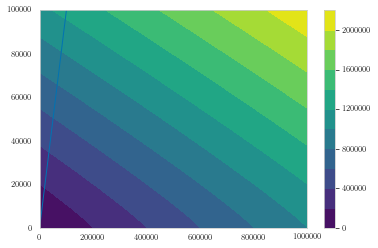

In [73]:
# Toeplitz
n = np.logspace(1, 6, 100)
m = np.logspace(1, 5, 100)
n, m = np.meshgrid(n, m)
time = n + m * np.log(m)
plt.contourf(n, m, time, 10)
plt.colorbar()
line = np.linspace(np.min(m),np.max(m), 100)
plt.plot(line, line)

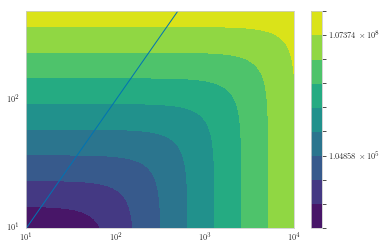

In [52]:
# Kronecker
from matplotlib import ticker
fig, ax = plt.subplots()

d = 2
n_hat = np.logspace(1, 4, 100)
m_hat = np.logspace(1, 2.7, 100)
n_hat, m_hat = np.meshgrid(n_hat, m_hat)
n = n_hat ** d
time = n+d*m_hat**(d+1)
cs = ax.contourf(n_hat, m_hat, time, locator=ticker.LogLocator(4, (0.1,)))
ax.set_yscale('log')
ax.set_xscale('log')

cbar = fig.colorbar(cs)

line = np.linspace(np.min(m_hat),np.max(m_hat), 100)
ax.plot(line, line)

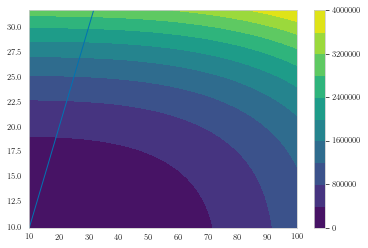

In [65]:
# Kronecker
d = 3
n_hat = np.logspace(1, 2, 100)
m_hat = np.logspace(1, 1.5, 100)
n_hat, m_hat = np.meshgrid(n_hat, m_hat)
n = n_hat ** d
time = n+d*m_hat**(d+1)
plt.contourf(n_hat, m_hat, time, 10)
plt.colorbar()
line = np.linspace(np.min(m_hat),np.max(m_hat), 100)
plt.plot(line, line)

## SSGP

## Variation starvation

In [1]:
from notebook_header import *

latexify(columns=4, fig_height=3)

In [5]:
def f(X):
    return np.sin((X[...,0]/(1/np.pi))**2)

def plot(model, subset):
    X_train = np.random.uniform(-1,0, subset)[:, None]
    Y_train = f(X_train)[:, None]
    
    model.init(X_train, Y_train)
    X_line = np.linspace(-1,1,100)[:, None]
    Y_line = f(X_line)[:, None]
    mean, var = model.get_statistics(X_line, full_cov=False)

    fig, ax = plt.subplots()
    CI = (2 * np.sqrt(var))[:,0]
    ax.scatter(X_train, Y_train, color='C1')
    ax.plot(X_line, Y_line, color='C1', linewidth=2, label="f")
    ax.plot(X_line, mean, c='C0', label="mean")
    ax.fill_between(X_line[:,0], mean[:,0] - CI, mean[:,0] + CI, alpha=0.3, color='C0', label="CI")
    ax.set_ylabel('$f(x)$')
    ax.set_xlabel('$x$')
    plt.legend(loc='lower left')
    return fig


gp = DKLGPModel.from_config({
        'n_iter': 150,
        'learning_rate': 0.1,
        'initial_parameters': {
            'outputscale': 1,
            'lengthscale': 0.1,
            'noise': 0.0001,
        },
        'noise_lower_bound': 1e-10,
        'eval_cg_tolerance': 1e-8,
        'max_cg_iter': 1500,
        'precond_size': 10,
        'use_cg': True,
})

ssgp = SSGP.from_config({
        'n_iter': 150,
        'learning_rate': 0.1,
        'feature_extractor_constructor': {
            'name': 'RFFEmbedding',
            'kwargs': {
                'M': 500,
                'ARD': False,
                'optimize_spectral_points': False,
            }
        },
        'initial_parameters': {
            'variance': 1,
            'lengthscale': 0.1,
            'noise': 0.0001,
        },
        'noise_lower_bound': 1e-10,
        'eval_cg_tolerance': 1e-8,
        'max_cg_iter': 1500,
        'precond_size': 10,
        'use_cg': True,
    })

{'variance': 1, 'lengthscale': 0.1, 'noise': 0.0001}
training on 100 data points of dim 1
Current hyperparameters: {'lengthscale': array([0.1], dtype=float32), 'variance': tensor([[1.0000]], grad_fn=<SoftplusBackward>), 'noise': 0.0001000116826617159}
Iter 1/150 - Loss: -3.047
Iter 21/150 - Loss: -1.564
Current hyperparameters: {'lengthscale': array([-0.11935289], dtype=float32), 'variance': tensor([[1.5658]], grad_fn=<SoftplusBackward>), 'noise': 0.00016163029067683965}
Iter 41/150 - Loss: -2.943
Current hyperparameters: {'lengthscale': array([-0.11750337], dtype=float32), 'variance': tensor([[1.6043]], grad_fn=<SoftplusBackward>), 'noise': 6.102873521740548e-05}
Iter 61/150 - Loss: -3.253
Iter 81/150 - Loss: -3.659
Current hyperparameters: {'lengthscale': array([-0.10686426], dtype=float32), 'variance': tensor([[1.5164]], grad_fn=<SoftplusBackward>), 'noise': 1.429219264537096e-05}
Iter 101/150 - Loss: -4.099
Current hyperparameters: {'lengthscale': array([-0.10398807], dtype=float32

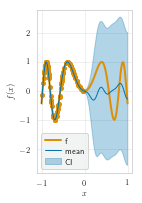

In [6]:
fig = plot(ssgp, 100)
savefig(fig, 'GP/variance-starvation-a.pdf')

{'variance': 1, 'lengthscale': 0.1, 'noise': 0.0001}
training on 500 data points of dim 1
Current hyperparameters: {'lengthscale': array([0.1], dtype=float32), 'variance': tensor([[1.0000]], grad_fn=<SoftplusBackward>), 'noise': 0.0001000116826617159}
Iter 1/150 - Loss: -3.500
Iter 21/150 - Loss: 34.016
Current hyperparameters: {'lengthscale': array([-0.52541435], dtype=float32), 'variance': tensor([[3.3322]], grad_fn=<SoftplusBackward>), 'noise': 0.0008854755433276296}
Iter 41/150 - Loss: 11.370
Current hyperparameters: {'lengthscale': array([-0.5541922], dtype=float32), 'variance': tensor([[4.7829]], grad_fn=<SoftplusBackward>), 'noise': 0.009511053562164307}
Iter 61/150 - Loss: 3.397
Iter 81/150 - Loss: 1.953
Current hyperparameters: {'lengthscale': array([-0.55580276], dtype=float32), 'variance': tensor([[5.0828]], grad_fn=<SoftplusBackward>), 'noise': 0.020819930359721184}
Iter 101/150 - Loss: 1.424
Current hyperparameters: {'lengthscale': array([-0.55588514], dtype=float32), 'var

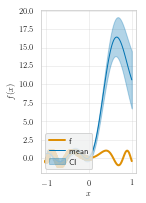

In [8]:
fig = plot(ssgp, 500)
savefig(fig, 'GP/variance-starvation-b.pdf')

{'variance': 1, 'lengthscale': 0.1, 'noise': 0.0001}
training on 2000 data points of dim 1
Current hyperparameters: {'lengthscale': array([0.1], dtype=float32), 'variance': tensor([[1.0000]], grad_fn=<SoftplusBackward>), 'noise': 0.0001000116826617159}
Iter 1/150 - Loss: nan
Iter 21/150 - Loss: -4.028
Current hyperparameters: {'lengthscale': array([-0.21602589], dtype=float32), 'variance': tensor([[2.1971]], grad_fn=<SoftplusBackward>), 'noise': 3.080621172557585e-05}
Iter 41/150 - Loss: nan
Current hyperparameters: {'lengthscale': array([-0.4930109], dtype=float32), 'variance': tensor([[5.2040]], grad_fn=<SoftplusBackward>), 'noise': 0.0006414813688024879}
Iter 61/150 - Loss: 11.129
Iter 81/150 - Loss: 3.296
Current hyperparameters: {'lengthscale': array([-0.45617354], dtype=float32), 'variance': tensor([[7.0057]], grad_fn=<SoftplusBackward>), 'noise': 0.001997486688196659}
Iter 101/150 - Loss: 1.274
Current hyperparameters: {'lengthscale': array([-0.43111327], dtype=float32), 'varian

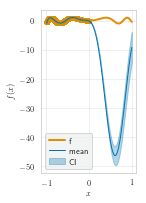

In [9]:
fig = plot(ssgp, 2000)
savefig(fig, 'GP/variance-starvation-c.pdf')

{'outputscale': 1, 'lengthscale': 0.1, 'noise': 0.0001}
training on 2000 data points of dim 1
Current hyperparameters: {'outputscale': array(0.99999994, dtype=float32), 'lengthscale': array([[0.10000005]], dtype=float32), 'noise': 0.0001000116826617159}
Iter 1/150 - Loss: -3.634
Iter 21/150 - Loss: -3.881
Current hyperparameters: {'outputscale': array(0.7677649, dtype=float32), 'lengthscale': array([[0.15979755]], dtype=float32), 'noise': 7.174400525400415e-05}
Iter 41/150 - Loss: nan
Current hyperparameters: {'outputscale': array(0.7244637, dtype=float32), 'lengthscale': array([[0.17091563]], dtype=float32), 'noise': 7.822651969036087e-05}
Iter 61/150 - Loss: nan
Iter 81/150 - Loss: -3.725
Current hyperparameters: {'outputscale': array(0.7220941, dtype=float32), 'lengthscale': array([[0.1715559]], dtype=float32), 'noise': 7.859359902795404e-05}
Iter 101/150 - Loss: nan
Current hyperparameters: {'outputscale': array(0.72197735, dtype=float32), 'lengthscale': array([[0.17158586]], dtype

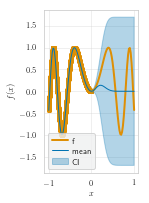

In [10]:
fig = plot(gp, 2000)
savefig(fig, 'GP/variance-starvation-d.pdf')

## Step

In [ ]:

import itertools
n_iters = [1000]
learning_rates = [0.005, 0.01]
parameters = itertools.product(n_iters, learning_rates)
models = [{
    'name': 'DKLGPModel',
    'kwargs': {
        'noise': None,
        'learning_rate': learning_rate,
        'n_iter': n_iter,
        'nn_kwargs': {
            'layers': [5,5,2],
        }
    }
} for (n_iter, learning_rate) in parameters]

for function_name in ['Step', 'SingleStep']:
    for model in models:
        config = {
            'tag': 'step',
            'obj_func': {'name': function_name, 'kwargs': {'noise': 0.01}},
            'model': model,
            'gp_samples': 1000,
        }
        run = execute(config_updates=config)

# Activation function

In [1]:
from notebook_header import *

In [ ]:
import GPy

kernel = GPy.kern.RBF(1)
kernel.lengthscale = 0.1

N = 50
X_train = np.random.uniform(-1,1, N)[:, None]

sigma = 0.1
covar = kernel.K(X_train, X_train) + np.diag(np.repeat(sigma, N))
Y_train = np.random.multivariate_normal(np.zeros(N), covar, size=1)
Y_train = np.moveaxis(Y_train, -1, 0)
plt.scatter(X_train, Y_train)

In [12]:
X_train = np.array([[ 0.853086  ],
       [-0.23067144],
       [ 0.86113593],
       [-0.82599705],
       [-0.89710593],
       [ 0.75934903],
       [-0.97011713],
       [ 0.56681636],
       [-0.98957737],
       [ 0.46685629],
       [ 0.06735907],
       [ 0.94440803],
       [-0.89091457],
       [ 0.79399842],
       [-0.48543096],
       [ 0.56492019],
       [-0.19286661],
       [-0.2892762 ],
       [ 0.19456283],
       [-0.99432098],
       [ 0.44823436],
       [-0.76543412],
       [-0.96376065],
       [ 0.45143933],
       [-0.87160865],
       [-0.24672361],
       [ 0.40807432],
       [ 0.69166429],
       [ 0.40541054],
       [-0.58297642],
       [ 0.21799714],
       [ 0.94434561],
       [ 0.34001888],
       [ 0.27564797],
       [ 0.64682967],
       [-0.18781059],
       [-0.61600925],
       [ 0.34797957],
       [ 0.8255336 ],
       [-0.95200041],
       [ 0.77177382],
       [-0.83677568],
       [-0.53470331],
       [-0.12074494],
       [ 0.80563942],
       [ 0.63289671],
       [ 0.75222708],
       [-0.51997883],
       [-0.34047344],
       [ 0.05712801]])

Y_train = np.array([[ 2.31735262],
       [-0.66365438],
       [ 2.01587257],
       [ 0.73260268],
       [-0.97119512],
       [ 2.08293516],
       [ 0.11420411],
       [ 2.13916484],
       [ 0.77391913],
       [ 1.08995819],
       [ 0.09323237],
       [ 1.81560936],
       [-0.28479994],
       [ 2.20607832],
       [ 1.20022713],
       [ 1.87622932],
       [-1.17975537],
       [-0.24787974],
       [-0.43309952],
       [ 0.61853305],
       [ 0.70307839],
       [ 0.8596501 ],
       [ 0.24614933],
       [ 0.19928007],
       [-0.06864543],
       [-0.38930095],
       [ 0.24726964],
       [ 2.12803223],
       [-0.3546101 ],
       [ 1.31656059],
       [-0.28443038],
       [ 1.54409173],
       [-0.59880897],
       [-0.32573679],
       [ 1.98318004],
       [-0.51192563],
       [ 1.00734027],
       [-0.80986395],
       [ 2.57306299],
       [-0.1150593 ],
       [ 1.73799179],
       [ 0.31276561],
       [ 1.41717458],
       [-1.43068885],
       [ 2.32035349],
       [ 2.5458196 ],
       [ 2.82417076],
       [ 0.93205056],
       [ 0.2391371 ],
       [-0.13118552]])

In [229]:
model = NormalizerModel.from_config({'model': {
        'name': 'DNNBLR',
        'kwargs': {
            'do_pretrain': False,
            #'pretrain_n_iter': 1000,
            'learning_rate': 0.1,
            'n_iter': 500,
            'nn_kwargs': {'layers': [50, 50, 5], 'output_activation': False, 'activation': 'relu'},
            'max_cg_iter': 30000,
            'precond_size': 20,
            'use_cg': False,
            'noise': None,
            #'use_double_precision': True,
            #'noise_lower_bound': 1e-8
        }
    }})
model.init(X_train, Y_train)

training on 50 data points of dim 1
Current hyperparameters: {'variance': tensor([[0.6931]], grad_fn=<SoftplusBackward>), 'noise': 0.6932471990585327}
Iter 1/500 - Loss: 1.118
Iter 21/500 - Loss: 0.432
Current hyperparameters: {'variance': tensor([[0.2760]], grad_fn=<SoftplusBackward>), 'noise': 0.07472292333841324}
Iter 41/500 - Loss: 0.364
Current hyperparameters: {'variance': tensor([[0.2928]], grad_fn=<SoftplusBackward>), 'noise': 0.08932280540466309}
Iter 61/500 - Loss: 0.805
Iter 81/500 - Loss: 0.374
Current hyperparameters: {'variance': tensor([[0.2880]], grad_fn=<SoftplusBackward>), 'noise': 0.08177359402179718}
Iter 101/500 - Loss: 0.336
Current hyperparameters: {'variance': tensor([[0.2026]], grad_fn=<SoftplusBackward>), 'noise': 0.08434954285621643}
Iter 121/500 - Loss: 0.322
Iter 141/500 - Loss: 0.307
Current hyperparameters: {'variance': tensor([[0.3111]], grad_fn=<SoftplusBackward>), 'noise': 0.09070614725351334}
Iter 161/500 - Loss: 0.323
Current hyperparameters: {'varia

predicting 100 points using 50 training points


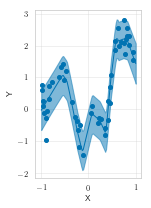

In [228]:
latexify(columns=3, fig_height=3)
X_line = np.linspace(-1,1, 100)[:, None]

mean, var = model.get_statistics(X_line, full_cov=False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_line, mean, c='C0')
ax.fill_between(X_line.reshape(-1),
                (mean + 2 * np.sqrt(var)).reshape(-1),
                (mean - 2 * np.sqrt(var)).reshape(-1), alpha=0.5, color='C0')    
ax.scatter(model.X.reshape(-1), model.Y, c='C0')
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.tight_layout()
savefig(fig, 'DKL/activation-relu.pdf')

In [225]:
model = NormalizerModel.from_config({'model': {
        'name': 'DNNBLR',
        'kwargs': {
            'do_pretrain': False,
            #'pretrain_n_iter': 1000,
            'learning_rate': 0.1,
            'n_iter': 400,
            'nn_kwargs': {'layers': [5, 5, 5], 'output_activation': False, 'activation': 'tanh'},
            'max_cg_iter': 30000,
            'precond_size': 20,
            'use_cg': True,
            'noise': None,
            #'use_double_precision': True,
            #'noise_lower_bound': 1e-8
        }
    }})
model.init(X_train, Y_train)

training on 50 data points of dim 1
Current hyperparameters: {'variance': tensor([[0.6931]], grad_fn=<SoftplusBackward>), 'noise': 0.6932471990585327}
Iter 1/400 - Loss: 1.100
Iter 21/400 - Loss: 0.839
Current hyperparameters: {'variance': tensor([[0.6631]], grad_fn=<SoftplusBackward>), 'noise': 0.2246781885623932}
Iter 41/400 - Loss: 0.939
Current hyperparameters: {'variance': tensor([[0.2201]], grad_fn=<SoftplusBackward>), 'noise': 0.23706600069999695}
Iter 61/400 - Loss: 0.808
Iter 81/400 - Loss: 0.741
Current hyperparameters: {'variance': tensor([[0.1419]], grad_fn=<SoftplusBackward>), 'noise': 0.20329661667346954}
Iter 101/400 - Loss: 0.721
Current hyperparameters: {'variance': tensor([[0.2325]], grad_fn=<SoftplusBackward>), 'noise': 0.19526852667331696}
Iter 121/400 - Loss: 0.688
Iter 141/400 - Loss: 0.827
Current hyperparameters: {'variance': tensor([[0.2751]], grad_fn=<SoftplusBackward>), 'noise': 0.210290789604187}
Iter 161/400 - Loss: 0.724
Current hyperparameters: {'variance

predicting 100 points using 50 training points


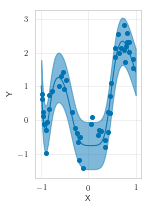

In [226]:
latexify(columns=3, fig_height=3)
X_line = np.linspace(-1,1, 100)[:, None]

mean, var = model.get_statistics(X_line, full_cov=False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_line, mean, c='C0')
ax.fill_between(X_line.reshape(-1),
                (mean + 2 * np.sqrt(var)).reshape(-1),
                (mean - 2 * np.sqrt(var)).reshape(-1), alpha=0.5, color='C0')    
ax.scatter(model.X.reshape(-1), model.Y, c='C0')
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.tight_layout()
savefig(fig, 'DKL/activation-tanh.pdf')

In [223]:
model = NormalizerModel.from_config({'model': {
        'name': 'DNNBLR',
        'kwargs': {
            'do_pretrain': False,
            #'pretrain_n_iter': 1000,
            'learning_rate': 0.1,
            'n_iter': 500,
            'nn_kwargs': {'layers': [50, 50, 50], 'output_activation': False, 'activation': ['tanh','relu']},
            'max_cg_iter': 30000,
            'precond_size': 20,
            'use_cg': True,
            'noise': None,
            #'use_double_precision': True,
            #'noise_lower_bound': 1e-8
        }
    }})
model.init(X_train, Y_train)

training on 50 data points of dim 1
Current hyperparameters: {'variance': tensor([[0.6931]], grad_fn=<SoftplusBackward>), 'noise': 0.6932471990585327}
Iter 1/500 - Loss: 1.120
Iter 21/500 - Loss: 0.606
Current hyperparameters: {'variance': tensor([[0.3766]], grad_fn=<SoftplusBackward>), 'noise': 0.0955648347735405}
Iter 41/500 - Loss: 0.442
Current hyperparameters: {'variance': tensor([[0.2274]], grad_fn=<SoftplusBackward>), 'noise': 0.1038840115070343}
Iter 61/500 - Loss: 0.471
Iter 81/500 - Loss: 0.390
Current hyperparameters: {'variance': tensor([[0.2407]], grad_fn=<SoftplusBackward>), 'noise': 0.0938083678483963}
Iter 101/500 - Loss: 0.537
Current hyperparameters: {'variance': tensor([[0.4476]], grad_fn=<SoftplusBackward>), 'noise': 0.08454184979200363}
Iter 121/500 - Loss: 0.385
Iter 141/500 - Loss: 0.326
Current hyperparameters: {'variance': tensor([[0.1985]], grad_fn=<SoftplusBackward>), 'noise': 0.11864756792783737}
Iter 161/500 - Loss: 0.373
Current hyperparameters: {'variance

predicting 100 points using 50 training points


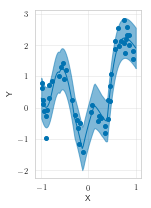

In [224]:
latexify(columns=3, fig_height=3)
X_line = np.linspace(-1,1, 100)[:, None]

mean, var = model.get_statistics(X_line, full_cov=False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_line, mean, c='C0')
ax.fill_between(X_line.reshape(-1),
                (mean + 2 * np.sqrt(var)).reshape(-1),
                (mean - 2 * np.sqrt(var)).reshape(-1), alpha=0.5, color='C0')    
ax.scatter(model.X.reshape(-1), model.Y, c='C0')
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.tight_layout()
savefig(fig, 'DKL/activation-rellu-tanh.pdf')

# Growth model

In [232]:
# step, max, mse
GP = [
[2.0000000000000000, 445.6482810731249060, 441.9896813885686129],
[3.0000000000000000, 429.7428786430056107, 427.3946885112696918],
[4.0000000000000000, 413.8290273032235973, 412.2338108087374167],
[5.0000000000000000, 398.1619266041057017, 396.6270947641613702],
[6.0000000000000000, 382.5027310507698530, 380.9016736455023988],
[7.0000000000000000, 367.1041525270277361, 365.2453876986372734],
[8.0000000000000000, 351.7837431739631029, 349.7146218483757139],
[9.0000000000000000, 336.6138797434891785, 334.5454348038402941],
[10.0000000000000000, 322.0600211434307312, 319.7727809620101880],
[11.0000000000000000, 308.0878742893974049, 305.4998525195805996],
[12.0000000000000000, 294.4864947787714300, 291.7756212584248487],
[13.0000000000000000, 281.2589891146753871, 278.5865813674649871],
[14.0000000000000000, 268.5686181642176962, 265.9702370436926344],
[15.0000000000000000, 256.4055008177019772, 253.9283058979081886],
[16.0000000000000000, 244.7790464988129315, 242.4528390079375981],
[17.0000000000000000, 233.6975211902145020, 231.5330888012383070],
[18.0000000000000000, 223.1361264203960673, 221.1473677242249778],
[19.0000000000000000, 213.0904257663787575, 211.2754764760675812],
[20.0000000000000000, 203.5397352963836966, 201.8940556122433350],
[21.0000000000000000, 194.4654816267366186, 192.9795543947966507],
[22.0000000000000000, 185.8427777743263505, 184.5064360702246518],
[23.0000000000000000, 177.6483918817730228, 176.4509089402318693],
[24.0000000000000000, 169.8587855753839904, 168.7896904742239315],
[25.0000000000000000, 162.4550848880098783, 161.4997986347881920],
[26.0000000000000000, 155.4128616000507463, 154.5613184172740091],
[27.0000000000000000, 148.7093472246078818, 147.9529847152137734],
[28.0000000000000000, 142.3276363998484157, 141.6574598103840401],
[29.0000000000000000, 136.2520413683560037, 135.6555605524461043],
[30.0000000000000000, 130.4608732836441050, 129.9339069173647658],
[31.0000000000000000, 124.9403303389926805, 124.4748292477806046],
[32.0000000000000000, 119.6754989683613530, 119.2646753738999479],
[33.0000000000000000, 114.6546672848244270, 114.2908109676081949],
[34.0000000000000000, 109.8601204159131157, 109.5404492377391819],
[35.0000000000000000, 105.2827260855283384, 105.0023678431157350],
[36.0000000000000000, 100.9104816587787354, 100.6651510969198142],
[37.0000000000000000, 96.7324808539051446, 96.5185112661093143],
[38.0000000000000000, 92.7388164659696486, 92.5527128950134284],
[39.0000000000000000, 88.9206848388384969, 88.7587528126686323],
[40.0000000000000000, 85.2683185611895169, 85.1277972928947690],
[41.0000000000000000, 81.7735013432647975, 81.6520629495485935],
[42.0000000000000000, 78.4303177248420980, 78.3239632025401136],
[43.0000000000000000, 75.2301681434346392, 75.1366288343114377],
[44.0000000000000000, 72.1652866959284438, 72.0833811372869633],
[45.0000000000000000, 69.2300223893744260, 69.1581067211284761],
[46.0000000000000000, 66.4179669421446306, 66.3549078180470104],
[47.0000000000000000, 63.7235379606972856, 63.6682958925311127],
[48.0000000000000000, 61.1418045047612395, 61.0930960434904620],
[49.0000000000000000, 58.6666578217664210, 58.6244074412854417],
[50.0000000000000000, 56.2946217233838979, 56.2573652499748249],
[51.0000000000000000, 54.0202617571940209, 53.9876608709695560],
[52.0000000000000000, 51.8395555568913551, 51.8111026748606491],
[53.0000000000000000, 49.7481696333306900, 49.7237218592582408],
[54.0000000000000000, 47.7437058446648734, 47.7217476872140622],
[55.0000000000000000, 45.8199493097181403, 45.8014949655587742],
[56.0000000000000000, 43.9752438145096676, 43.9594514793084272],
[57.0000000000000000, 42.2059325025711587, 42.1924140290532677],
[58.0000000000000000, 40.5087054870418797, 40.4971975183731061],
[59.0000000000000000, 38.8805950654113985, 38.8707326647449918],
[60.0000000000000000, 37.3185037486764486, 37.3101900574781240],
[61.0000000000000000, 35.8199049557242688, 35.8128106977387688],
[62.0000000000000000, 34.3819845189191255, 34.3759583355281393],
[63.0000000000000000, 33.0022193519125722, 32.9971239765543913],
[64.0000000000000000, 31.6784567295908346, 31.6739330459113262],
[65.0000000000000000, 30.4081408895890490, 30.4040893589382897],
[66.0000000000000000, 29.1890419093888340, 29.1854058668996927],
[67.0000000000000000, 28.0190476746247441, 28.0157876737748666],
[68.0000000000000000, 26.8961501460980799, 26.8932372722209934],
[69.0000000000000000, 25.8184535869804677, 25.8158348847954571],
[70.0000000000000000, 24.7840897320256772, 24.7817355201920684],
[71.0000000000000000, 23.7913529858742550, 23.7891957596951222],
[72.0000000000000000, 22.8384785162816115, 22.8365055404789032],
[73.0000000000000000, 21.9238669620754081, 21.9220658426651411],
[74.0000000000000000, 21.0459709809274500, 21.0443246618679041],
[75.0000000000000000, 20.2033059664736356, 20.2018074555708154],
[76.0000000000000000, 19.3944470734659262, 19.3930816234079444],
[77.0000000000000000, 18.6180298872513958, 18.6167912264742874],
[78.0000000000000000, 17.8727563606735202, 17.8716191219589753],
[79.0000000000000000, 17.1573499948171957, 17.1563227115441812],
[80.0000000000000000, 16.4706248190468614, 16.4696900362492684],
[81.0000000000000000, 15.8114206067421037, 15.8105705146973374],
[82.0000000000000000, 15.1786278733707150, 15.1778570710036540],
[83.0000000000000000, 14.5711831780063221, 14.5704870326901066],
[84.0000000000000000, 13.9880783698881714, 13.9874426622958712],
[85.0000000000000000, 13.4283202841852471, 13.4277480316941364],
[86.0000000000000000, 12.8909795595864125, 12.8904640340413614],
[87.0000000000000000, 12.3751619963750272, 12.3746927365063133],
[88.0000000000000000, 11.8799951475357375, 11.8795717186532777],
[89.0000000000000000, 11.4046520152423909, 11.4042714184717617],
[90.0000000000000000, 10.9483405170267361, 10.9479975030948484],
[91.0000000000000000, 10.5102988145845302, 10.5099873284017118],
[92.0000000000000000, 10.0897895845373569, 10.0895094914321817],
[93.0000000000000000, 9.6861127881784341, 9.6858611186050432],
[94.0000000000000000, 9.2985937112080137, 9.2983669550225390],
[95.0000000000000000, 8.9265845058253035, 8.9263800771057511],
[96.0000000000000000, 8.5694667778643634, 8.5692805168428094],
[97.0000000000000000, 8.2266368078981031, 8.2264704787595289],
[98.0000000000000000, 7.8975276187993586, 7.8973779096458205],
[99.0000000000000000, 7.5815893094168132, 7.5814539406980659],
]

DKL = [
[2.0000000000000000, 450.8433498243580857, 443.6423055679107961],
[3.0000000000000000, 435.9540188579705955, 429.7987390921080078],
[4.0000000000000000, 418.8541774210868880, 415.2942194005801753],
[5.0000000000000000, 401.7903473838293849, 396.4042368253930704],
[6.0000000000000000, 385.7056715491933119, 372.6206397934695929],
[7.0000000000000000, 377.0243953402748502, 347.4756309753956316],
[8.0000000000000000, 327.5524709356350286, 327.4264717393749038],
[9.0000000000000000, 314.3234780966818107, 314.3234167056253909],
[10.0000000000000000, 301.7504980065536984, 301.7504980027405850],
[11.0000000000000000, 289.6804780879128884, 289.6804780878645147],
[12.0000000000000000, 278.0932589648332396, 278.0932589643927031],
[13.0000000000000000, 266.9695286058749844, 266.9695286058083070],
[14.0000000000000000, 256.2907474615949468, 256.2907474615625461],
[15.0000000000000000, 246.0391175632094019, 246.0391175631091301],
[16.0000000000000000, 236.1975528606326407, 236.1975528605644286],
[17.0000000000000000, 226.7496507462101363, 226.7496507461005422],
[18.0000000000000000, 217.6796647163582747, 217.6796647162126703],
[19.0000000000000000, 208.9724781277072907, 208.9724781275359078],
[20.0000000000000000, 200.6135790025991810, 200.6135790024194705],
[21.0000000000000000, 192.5890358425140221, 192.5890358423189923],
[22.0000000000000000, 184.8854744088739608, 184.8854744086348205],
[23.0000000000000000, 177.4900554325313351, 177.4900554323189112],
[24.0000000000000000, 170.3904532152400861, 170.3904532150663158],
[25.0000000000000000, 163.5748350866333567, 163.5748350865043790],
[26.0000000000000000, 157.0318416831560171, 157.0318416830739920],
[27.0000000000000000, 150.7505680159983967, 150.7505680157620702],
[28.0000000000000000, 144.7205452952503038, 144.7205452951166649],
[29.0000000000000000, 138.9317234833952170, 138.9317234833132204],
[30.0000000000000000, 133.3744545441268201, 133.3744545439769809],
[31.0000000000000000, 128.0394763622780374, 128.0394763622101379],
[32.0000000000000000, 122.9178973077887349, 122.9178973077410717],
[33.0000000000000000, 118.0011814154913736, 118.0011814154318017],
[34.0000000000000000, 113.2811341589203948, 113.2811341588108860],
[35.0000000000000000, 108.7498887925321469, 108.7498887924521114],
[36.0000000000000000, 104.3998932408785549, 104.3998932407585869],
[37.0000000000000000, 100.2238975111840773, 100.2238975111338277],
[38.0000000000000000, 96.2149416106904027, 96.2149416106840789],
[39.0000000000000000, 92.3663439462579845, 92.3663439462562508],
[40.0000000000000000, 88.6716901884301478, 88.6716901884034030],
[41.0000000000000000, 85.1248225809140422, 85.1248225808663790],
[42.0000000000000000, 81.7198296776441566, 81.7198296776357864],
[43.0000000000000000, 78.4510364911675424, 78.4510364879031812],
[44.0000000000000000, 75.3129950332604494, 75.3129950076064176],
[45.0000000000000000, 72.3004756929840369, 72.3004752500190051],
[46.0000000000000000, 69.4084562105745135, 69.4084562069931934],
[47.0000000000000000, 66.6321179826827574, 66.6321179704164877],
[48.0000000000000000, 63.9668332735218428, 63.9668332348624062],
[49.0000000000000000, 61.4081602951173409, 61.4081599386559915],
[50.0000000000000000, 58.9518335267748625, 58.9518334846060483],
[51.0000000000000000, 56.5937609894044726, 56.5937602255730781],
[52.0000000000000000, 54.3300098026629712, 54.3300096797426733],
[53.0000000000000000, 52.1568114119418169, 52.1568094805713400],
[54.0000000000000000, 50.0705371239564556, 50.0705370170357114],
[55.0000000000000000, 48.0677155839075567, 48.0677154908375073],
[56.0000000000000000, 46.1450070239225170, 46.1450069137998042],
[57.0000000000000000, 44.2992072985416598, 44.2992066575132384],
[58.0000000000000000, 42.5272383776009519, 42.5272383289535369],
[59.0000000000000000, 40.8261488401258248, 40.8261487903047069],
[60.0000000000000000, 39.1931028845392575, 39.1931028742063958],
[61.0000000000000000, 37.6253787667901634, 37.6253787066276359],
[62.0000000000000000, 36.1203650872084836, 36.1203636901201222],
[63.0000000000000000, 34.6755502413998329, 34.6755491283433912],
[64.0000000000000000, 33.2885274315194692, 33.2885271294077967],
[65.0000000000000000, 31.9569860374795098, 31.9569860080810955],
[66.0000000000000000, 30.6787065876487759, 30.6787065815754438],
[67.0000000000000000, 29.4515583235861413, 29.4515583129731553],
[68.0000000000000000, 28.2734960741181567, 28.2734959758170596],
[69.0000000000000000, 27.1425561492669658, 27.1425561150281283],
[70.0000000000000000, 26.0568542930759577, 26.0568539294035872],
[71.0000000000000000, 25.0145797466047952, 25.0145797440302893],
[72.0000000000000000, 24.0139965599792049, 24.0139965494264302],
[73.0000000000000000, 23.0534368106291367, 23.0534366951754244],
[74.0000000000000000, 22.1312992313760333, 22.1312991948427218],
[75.0000000000000000, 21.2460479079818469, 21.2460472846264565],
[76.0000000000000000, 20.3962053708564781, 20.3962053310948264],
[77.0000000000000000, 19.5803578846680466, 19.5803571890472980],
[78.0000000000000000, 18.7971428976761672, 18.7971428014267090],
[79.0000000000000000, 18.0452576495863468, 18.0452571471545511],
[80.0000000000000000, 17.3234468695936812, 17.3234468151668821],
[81.0000000000000000, 16.6305089948218665, 16.6305089427899482],
[82.0000000000000000, 15.9652886353069334, 15.9652886024119649],
[83.0000000000000000, 15.3266770896261733, 15.3266770754774377],
[84.0000000000000000, 14.7136100667921710, 14.7136100063848971],
[85.0000000000000000, 14.1250657063792460, 14.1250656073396392],
[86.0000000000000000, 13.5600629813270643, 13.5600629694086816],
[87.0000000000000000, 13.0176605409069452, 13.0176604636462798],
[88.0000000000000000, 12.4969540453294030, 12.4969540374971988],
[89.0000000000000000, 11.9970760441246966, 11.9970758873990242],
[90.0000000000000000, 11.5171933105139033, 11.5171928670949448],
[91.0000000000000000, 11.0565051329740527, 11.0565051210693124],
[92.0000000000000000, 10.6142482417180872, 10.6142450959871901],
[93.0000000000000000, 10.1896752338379883, 10.1896750936622080],
[94.0000000000000000, 9.7820881270654354, 9.7820880927211871],
[95.0000000000000000, 9.3908046017695597, 9.3908045706131809],
[96.0000000000000000, 9.0151724169209047, 9.0151724013119754],
[97.0000000000000000, 8.6545667662139749, 8.6545655817427356],
[98.0000000000000000, 8.3083831799795007, 8.3083829083423559],
[99.0000000000000000, 7.9760475908497028, 7.9760475787124054],
]
GP = np.array(GP)
DKL = np.array(DKL)

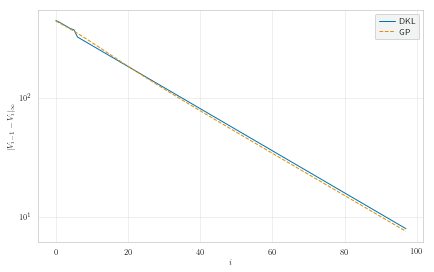

In [261]:
lines = cycle_lines()
markers = cycle_markers()
latexify(columns=1)

fig, ax = plt.subplots()
ax.plot(DKL[:,1], linestyle=next(lines), label='DKL')
ax.plot(GP[:,1], linestyle=next(lines), label='GP')
ax.set_yscale('log')
ax.set_xlabel('$i$')
ax.set_ylabel('$|V_{i-1}-V_{i}|_\infty$')
ax.legend()
savefig(fig, 'DKL/growth-model-max.pdf')

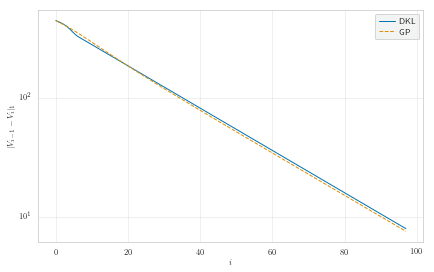

In [262]:
lines = cycle_lines()
latexify(columns=1)
fig, ax = plt.subplots()
ax.plot(DKL[:,2], linestyle=next(lines), label='DKL')
ax.plot(GP[:,2], linestyle=next(lines), label='GP')
ax.set_yscale('log')
ax.set_xlabel('$i$')
ax.set_ylabel('$|V_{i-1}-V_{i}|_1$')
ax.legend()
savefig(fig, 'DKL/growth-model-mae.pdf')